# Idea of this file
In this notebook i want to explore the data after arranging everything. Let's see.

In [1]:
import re
import time
import zipfile

import numpy as np
import pandas as pd
from pathlib import Path
import os

In [3]:
data_path = Path('/media/<User>/DC/MAP_CreationOfNewDatasetsForDFL/code&data/0_raw_collected_data/')
assert data_path.exists()

#### Get all all files

In [4]:
def is_ds_stores_or_in_backup(file_path: Path):
    return file_path.match(".DS_Store") or file_path.match(".backup")

In [5]:
def is_not_file(file_path: Path):
    return not file_path.is_file()

In [6]:
def is_txt(file_path: Path):
    if file_path.suffix[1:] == 'txt':
        print("txt file found, will drop", file_path)
        return True
    return False


In [7]:
pattern_all_visible_files = '**/*.*'
all_files = list(data_path.glob(pattern_all_visible_files))

In [8]:
df = pd.DataFrame(all_files, columns=['file_path'])
mask = df['file_path'].map(is_not_file)
df = df[~mask]
mask = df['file_path'].map(is_ds_stores_or_in_backup)
df = df[~mask]
mask = df['file_path'].map(is_txt)
df = df[~mask]
df.head(1)

txt file found, will drop /media/<User>/DC/MAP_CreationOfNewDatasetsForDFL/code&data/0_raw_collected_data/Heqing/device1/3_thetick_4h/collections.txt
txt file found, will drop /media/<User>/DC/MAP_CreationOfNewDatasetsForDFL/code&data/0_raw_collected_data/Heqing/device2/1_normal/note.txt


,file_path
0,/media//DC/MAP_CreationOfNewDatasetsForDFL/...


In [9]:
df = df.reset_index(drop=True)
df.index

RangeIndex(start=0, stop=622, step=1)

#### Check filetypes

In [10]:
def get_file_type(file_path: Path):
    if not file_path.suffix[1:]:
        print("Found a file without type: ", file_path, file_path.suffix)
        return 'no_filetype'
    return file_path.suffix[1:]

In [11]:
df['filetype'] = df['file_path'].map(lambda a: get_file_type(a))
df['filetype'].value_counts()

filetype
csv    530
zip     92
Name: count, dtype: int64

#### Filesize

In [12]:
def get_file_size(file_path: Path):
    return file_path.stat().st_size

In [13]:
df['filesize_bytes'] = df['file_path'].map(lambda a: get_file_size(a))
df.head(1)

,file_path,filetype,filesize_bytes
0,/media//DC/MAP_CreationOfNewDatasetsForDFL/...,csv,49419


#### Parse Folder types

In [13]:
pattern = re.compile(
    r"0_raw_collected_data/(?P<researcher_name>\w+)/(?P<device_name>\w+)/(?P<label>\w+)/(?P<data_source>\w+)/(?P<file_name>[\w.-]+\.(?:csv|zip))$")


def get_groups(file_path: Path):
    match = pattern.search(str(file_path))
    if match:
        assert len(match.groups()) == 5, f"Matched groups are not 5, but: {len(match.groups())}"
        return match.groups()
    raise Exception("No match found for: ", file_path)

In [14]:
dicts = df['file_path'].map(lambda a: get_groups(a))
dicts_df = pd.DataFrame(dicts.tolist(),
                        columns=['researcher_name', 'device_name', 'label', 'data_source', 'file_name'])
df = pd.concat([df, dicts_df],
               axis=1)

In [15]:
# df2 = df.copy(deep=True)
df.replace({'data_source': {'FLSYS': 'FLS_data', 'Block': 'block_data', 'KERN': 'KERN_data', 'NET': 'network_data',
                            "Network": 'network_data', "ENTROPY": "entropy_data", "Entropy": "entropy_data",
                            "BLOCK": "block_data", "RES": "RES_data"}}, inplace=True)
df.value_counts('data_source')

data_source
SYS_data        92
KERN_data       91
FLS_data        91
RES_data        91
block_data      91
network_data    91
entropy_data    75
Name: count, dtype: int64

#### Find missing entropy data

In [17]:
table = df.pivot_table(index=['researcher_name', 'device_name', 'label'],
                       columns='data_source',
                       aggfunc='size',
                       fill_value=0)

table = table.reindex(sorted(table.columns), axis=1)
table.reset_index(inplace=True)
table[table['entropy_data'] == 0][['researcher_name', 'device_name', 'label', 'entropy_data']]

data_source,researcher_name,device_name,label,entropy_data
40,Xi,sensor_1,5_httpbackdoor,0
43,Xi,sensor_1,8_bdvl,0
45,Xi,sensor_2,1_normal,0
47,Xi,sensor_2,3_thetick,0
49,Xi,sensor_2,5_httpbackdoor,0
51,Xi,sensor_2,7_backdoor,0
52,Xi,sensor_2,8_bdvl,0
53,Xi,sensor_2,9_xmrig,0
54,Zien,device1,1_normal,0
61,Zien,device1,8_bdvl,0


#### Maybe used for droping the ones where entropy_data is missing

In [18]:
# for row in table[table['entropy_data'] == 0].iterrows():
#     mask = (df['researcher_name'] == row[1]['researcher_name']) & \
#            (df['device_name'] == row[1]['device_name']) & \
#            (df['experiment'] == row[1]['experiment']) & \
#            (df['feature'] == 'entropy_data')

#### Checking none values

In [18]:
df[df.isna().any(axis=1)]

,file_path,filetype,filesize_bytes,researcher_name,device_name,label,data_source,file_name


#### Get Timestamps of files

In [20]:
def is_timestamp_in_microseconds(df_x: pd.DataFrame) -> bool:
    max_timestamp = df_x["timestamp"].max()
    return max_timestamp > time.time()


def clean_and_set_index_timestamp(df_x: pd.DataFrame):
    if "timestamp" in df_x.columns:
        pass
    elif "time" in df_x.columns:
        df_x["timestamp"] = df_x["time"]
    elif "Time" in df_x.columns:
        df_x["timestamp"] = df_x["Time"]

    df_all = df_x.copy()
    # is set to none if not numeric => then dropping the none values
    df_x["timestamp"] = pd.to_numeric(df_x["timestamp"], errors="coerce")

    tobe_dropped_indices = df_x.index[df_x['timestamp'].isnull()]
    if tobe_dropped_indices.any():
        print("! Dropped rows in DataFrames:", tobe_dropped_indices.shape)
        for index in tobe_dropped_indices:
            print(df_x.iloc[index])

        df_x.dropna(subset=['timestamp'], inplace=True)
        df_x.reset_index(inplace=True)

    if is_timestamp_in_microseconds(df_x):
        # df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df_x["timestamp"] = pd.to_datetime(np.floor(df_x["timestamp"] / 1000), unit="s")
    else:
        df_x["timestamp"] = pd.to_datetime(df_x["timestamp"], unit="s")

    df_x.set_index("timestamp", inplace=True, drop=True)

    df_x.drop(columns=["time", "Time", "timestamp"], inplace=True, errors="ignore")
    df_x.sort_index(inplace=True)

In [19]:
def extract_timestamps_log_files(zip_file_path, resample_time_window) -> pd.DataFrame:
    log_files = []
    try:
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            for file_name in zip_ref.namelist():
                if file_name.endswith('.log'):
                    base_name = os.path.basename(file_name)
                    file_name_without_extension = os.path.splitext(base_name)[0]
                    log_files.append(file_name_without_extension)
    except Exception as e:
        print("Error in file: ", zip_file_path)
        print(e)

    log_df = pd.DataFrame(log_files, columns=['timestamp'])
    return log_df


def get_all_timestamps(file_path: Path, filetype: str, resample_time_window=None):
    if filetype == "csv":
        df_sizes = pd.read_csv(str(file_path))
    elif filetype == "zip":
        df_sizes = extract_timestamps_log_files(file_path, resample_time_window)
    else:
        raise Exception("Filetype not supported: ", filetype)

    try:
        clean_and_set_index_timestamp(df_sizes)
    except Exception as e:
        print("Error in file: ", file_path)
        raise e

    if resample_time_window:
        df_sizes = df_sizes.resample(resample_time_window).size()
        df_sizes = df_sizes.to_frame(name='vector_count')
    else:
        df_sizes = df_sizes.filter(items=['timestamp'])
    return df_sizes.index.min(), df_sizes.index.max(), df_sizes

In [21]:
def get_vector_detailed_title(row) -> str:
    return row['researcher_name'] + "_" + row['device_name'] + "_" + row['label'] + "_" + row['data_source']


def get_group_vector_title(row) -> str:
    return row['researcher_name'] + "_" + row['device_name']  # + "_" + row['experiment'] + "_" + row['feature']

In [22]:
def prepare_files(row, resample_time_window):
    if row["filetype"] != "csv" and row["filetype"] != "zip":
        return None

    min_t, max_t, df_t = get_all_timestamps(row['file_path'], row["filetype"],
                                            resample_time_window=resample_time_window)
    name = get_vector_detailed_title(row)
    df_t["name"] = name
    name_group = get_group_vector_title(row)
    df_t["group"] = name_group
    df_t["label"] = row['label']
    df_t["data_source"] = row['data_source']
    return df_t

In [23]:
# if None: no resampling just timestamp is extraced from csv files; else resampling and counting the timestamps
TIME_WINDOW = None  #"1h"

dfs = []
for k, row in df.iterrows():
    x = prepare_files(row, TIME_WINDOW)
    if x is None or x.empty:
        print("filetype not csv, skipping: ", row['file_path'])
        continue
    dfs.append(x)

vectors_df = pd.concat(dfs)

Error in file:  /media/<User>/DC/MAP_CreationOfNewDatasetsForDFL/code&data/0_raw_collected_data/Heqing/device1/3_thetick_4h/SYS_data/device1_thetick_1h_24.7G.zip
File is not a zip file
filetype not csv, skipping:  /media/<User>/DC/MAP_CreationOfNewDatasetsForDFL/code&data/0_raw_collected_data/Heqing/device1/3_thetick_4h/SYS_data/device1_thetick_1h_24.7G.zip
! Dropped rows in DataFrames: (2,)
time                                                time
cpu                                                  cpu
seconds                                          seconds
ioread                                            ioread
iowrite                                          iowrite
                                         ...            
rpm:rpm_return_int                    rpm:rpm_return_int
fib:fib_table_lookup                fib:fib_table_lookup
raw_syscalls:sys_enter            raw_syscalls:sys_enter
random:credit_entropy_bits    random:credit_entropy_bits
timestamp                          

In [24]:
print("LENGTH: ", vectors_df.shape)
vectors_df.head(1)

LENGTH:  (21582484, 4)


,name,group,label,data_source
timestamp,,,,
2023-11-05 16:06:47,Heqing_device1_1_normal_4h_block_data,Heqing_device1,1_normal_4h,block_data


In [25]:
vectors_df["group"].value_counts()

group
Heqing_device2    4051353
Heqing_device1    3550553
Xi_sensor_1       3346411
Xi_sensor_2       2727295
Zien_device1      2552527
Zien_device2      2492292
Jing_device2      1473830
Jing_device1      1388223
Name: count, dtype: int64

In [26]:
x = pd.read_csv(
    "/media/<User>/DC/MAP_CreationOfNewDatasetsForDFL/code&data/0_raw_collected_data/Heqing/device2/1_normal/RES_data/res_1699542432.csv")
x.iloc[317:320]

,time,cpu,seconds,ioread,iowrite,ioreadbytes,iowritebytes,ioreadtime,iowritetime,iobusytime,...,napi:napi_poll,tcp:tcp_probe,net:netif_rx,gpio:gpio_value,irq:softirq_exit,pagemap:mm_lru_activate,rpm:rpm_return_int,fib:fib_table_lookup,raw_syscalls:sys_enter,random:credit_entropy_bits
317,1699547421,89.1,5.021030107,0,4,0,36864,0,7,40,...,9129,3028,2,26,13312,14203,38,787,361171,97
318,time,cpu,seconds,ioread,iowrite,ioreadbytes,iowritebytes,ioreadtime,iowritetime,iobusytime,...,napi:napi_poll,tcp:tcp_probe,net:netif_rx,gpio:gpio_value,irq:softirq_exit,pagemap:mm_lru_activate,rpm:rpm_return_int,fib:fib_table_lookup,raw_syscalls:sys_enter,random:credit_entropy_bits
319,1699548918,41.6,5.011188518,1,1,1,1,1,1,1,...,7114,2006,2,10,12002,2642,21,584,167627,75


# Visualizing
#### Arranging Data

In [27]:
def resample_summing_vector_count(resample_df: pd.DataFrame, time_window: str):
    series = []
    for timestamp, group_df in resample_df.resample(time_window, on="timestamp"):
        features = {
            "timestamp": timestamp,
            "vector_count": group_df["vector_count"].sum(),
            "group": group_df["group"].iloc[0] if group_df["group"].shape[0] > 0 else None
        }
        series.append(features)

    return pd.DataFrame(series)


def resample_counting_timestamps(resample_df: pd.DataFrame, time_window: str):
    series = []
    for timestamp, group_df in resample_df.resample(time_window, on="timestamp"):
        features = {
            "timestamp": timestamp,
            "vector_count": group_df.size,
            "group": group_df["group"].iloc[0] if group_df["group"].shape[0] > 0 else None
        }
        series.append(features)

    return pd.DataFrame(series)

In [28]:
# assert 1 == 0
# 
# copy_df = vectors_df.copy()
# copy_df.reset_index(inplace=True)
# 
# TIME_WINDOW = "1d"
# copy_df = resample(copy_df, TIME_WINDOW)
# 
# xs = copy_df["group"]
# ys = copy_df["timestamp"]
# z = copy_df["vector_count"]
# 
# xs.shape, ys.shape, z.shape

In [29]:
copy_df = vectors_df.copy()
copy_df.reset_index(inplace=True)

TIME_WINDOW = "10min"
time_sampled_df = resample_counting_timestamps(copy_df, TIME_WINDOW)
time_sampled_df

,timestamp,vector_count,group
0,2023-10-21 09:10:00,33175,Jing_device1
1,2023-10-21 09:20:00,38145,Jing_device1
2,2023-10-21 09:30:00,43150,Jing_device1
3,2023-10-21 09:40:00,35675,Jing_device1
4,2023-10-21 09:50:00,39280,Jing_device1
...,...,...,...
4026,2023-11-18 08:10:00,65580,Zien_device1
4027,2023-11-18 08:20:00,56405,Zien_device1
4028,2023-11-18 08:30:00,61010,Zien_device1
4029,2023-11-18 08:40:00,58670,Zien_device1


In [31]:
experiment_df = vectors_df.copy()
experiment_df.replace(
    {'label': {'1_normal_4h': '1_normal', '3_thetick_4h': '3_thetick', "2_ransomware_4h": "2_ransomware",
               "5_httpbackcoor": "5_httpbackdoor"}},
    inplace=True)
experiment_df["label"].value_counts()

label
2_ransomware      2681199
6_beurk           2643148
5_httpbackdoor    2603616
3_thetick         2571045
1_normal          2419858
7_backdoor        2410855
4_bashlite        2166862
8_bdvl            2123799
9_xmrig           1962102
Name: count, dtype: int64

In [34]:
counting_label_df = experiment_df.groupby('label').size()
counting_label_df = counting_label_df.to_frame(name='vector_count')
counting_label_df

,vector_count
label,
1_normal,2419858
2_ransomware,2681199
3_thetick,2571045
4_bashlite,2166862
5_httpbackdoor,2603616
6_beurk,2643148
7_backdoor,2410855
8_bdvl,2123799
9_xmrig,1962102


In [35]:
counting_df = vectors_df.groupby('group').size()
counting_df = counting_df.to_frame(name='vector_count')
counting_df

,vector_count
group,
Heqing_device1,3550553
Heqing_device2,4051353
Jing_device1,1388223
Jing_device2,1473830
Xi_sensor_1,3346411
Xi_sensor_2,2727295
Zien_device1,2552527
Zien_device2,2492292


In [36]:
# sampled_df = vectors_df.sample(frac=0.5)
vectors_df["data_source"].value_counts()

data_source
network_data    20645450
entropy_data      549300
block_data         96577
SYS_data           87344
RES_data           80386
KERN_data          79765
FLS_data           43662
Name: count, dtype: int64

In [37]:
device_fam_df = vectors_df.copy()
rp4 = "Raspberry Pi 4"
rp3 = "Raspberry Pi 3"
device_fam_df.replace(
    {'group': {'Heqing_device1': rp4, 'Heqing_device2': rp4, "Jing_device1": rp3,
               "Jing_device2": rp3, "Xi_sensor_1": rp3, "Xi_sensor_2": rp3, "Zien_device1": rp3, "Zien_device2": rp3}},
    inplace=True)
device_fam_df["group"].value_counts()

group
Raspberry Pi 3    13980578
Raspberry Pi 4     7601906
Name: count, dtype: int64

#### Visualize
##### Barplot
###### Total Number of Vectors by Group

In [67]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# 
# sns.set_theme(style="whitegrid")
# # Assuming copy_df is your DataFrame containing the data
# 
# # Set up the figure size based on the values in z
# plt.figure(figsize=(16, 6))  # You can adjust the size as needed
# 
# sns.barplot(x="group", y="vector_count", data=counting_df, log_scale=True, palette="muted", estimator=lambda x: x,
#             hue="group")
# 
# # Set labels and title
# plt.xlabel("Group")
# plt.ylabel("Number of Vectors (log)")
# plt.title("Total Number of Vectors by Group")
# 
# # Show plot
# plt.show()


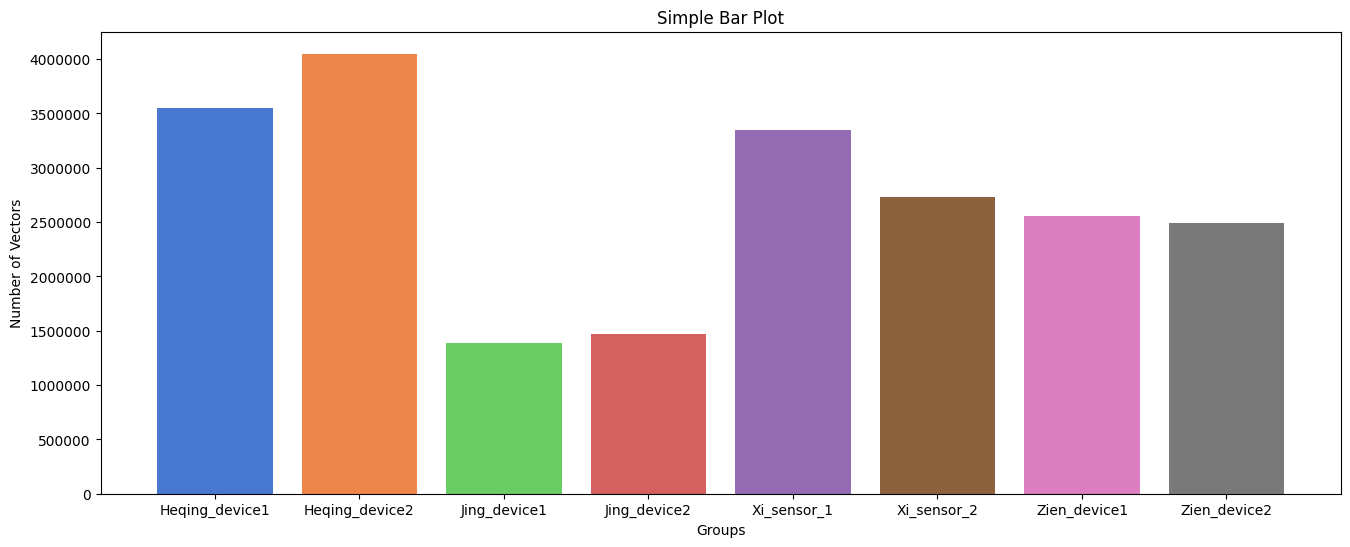

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data
x = counting_df.index
y = counting_df["vector_count"]

plt.figure(figsize=(16, 6))
# Create bar plot
colors = sns.color_palette("muted", n_colors=len(x))
plt.bar(x, y, color=colors)

# Add labels and title
plt.xlabel('Devices')
plt.ylabel('Number of Vectors')
plt.title('Number of Vectors per Device')

plt.yscale("linear")
plt.ticklabel_format(style='plain', axis='y')
# Show the plot
plt.show()



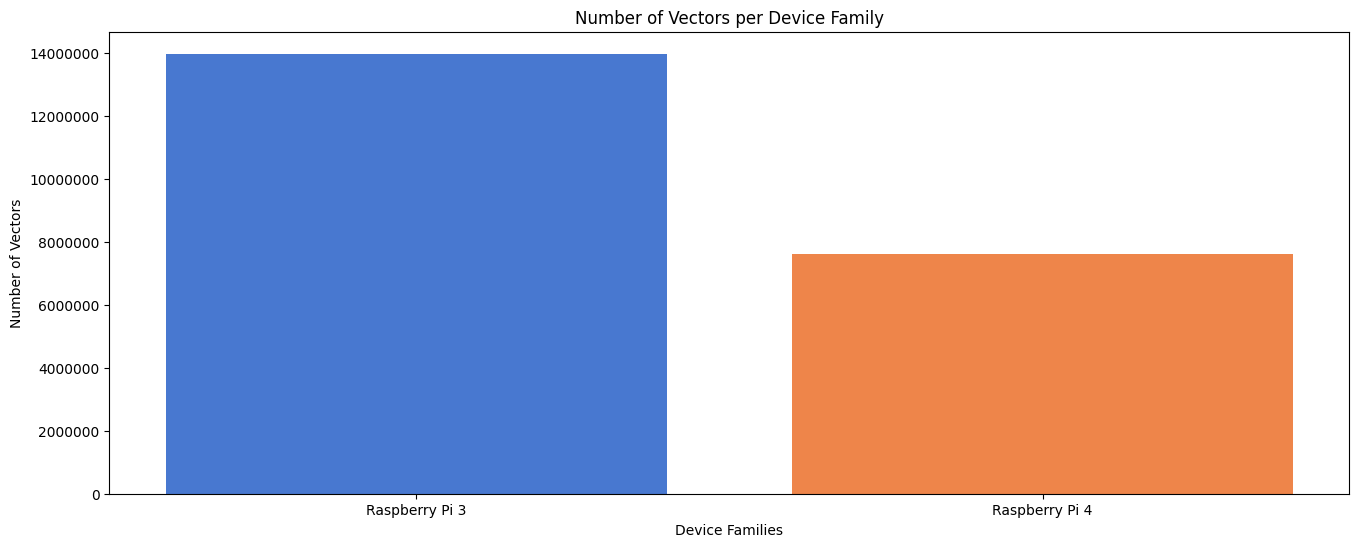

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data
device_fam_count_df = device_fam_df.groupby('group').size()
device_fam_count_df = device_fam_count_df.to_frame(name='vector_count')
x = device_fam_count_df.index
y = device_fam_count_df["vector_count"]

plt.figure(figsize=(16, 6))
# Create bar plot
colors = sns.color_palette("muted", n_colors=len(x))
plt.bar(x, y, color=colors)

# Add labels and title
plt.xlabel('Device Families')
plt.ylabel('Number of Vectors')
plt.title('Number of Vectors per Device Family')

plt.yscale("linear")
plt.ticklabel_format(style='plain', axis='y')
# Show the plot
plt.show()



###### Total Number of Vectors by Experiment

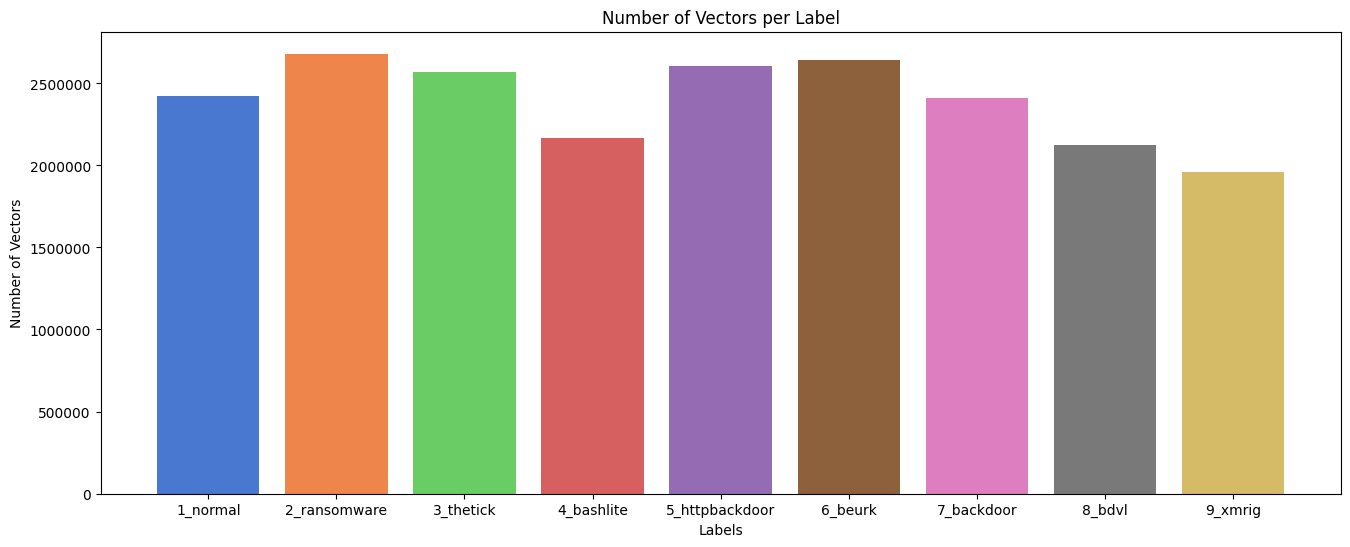

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data
x = counting_label_df.index
y = counting_label_df["vector_count"]

plt.figure(figsize=(16, 6))
# Create bar plot
colors = sns.color_palette("muted", n_colors=len(x))
plt.bar(x, y, color=colors)

# Add labels and title
plt.xlabel('Labels')
plt.ylabel('Number of Vectors')
plt.title('Number of Vectors per Label')

plt.yscale("linear")
plt.ticklabel_format(style='plain', axis='y')
# Show the plot
plt.show()



##### violinplot

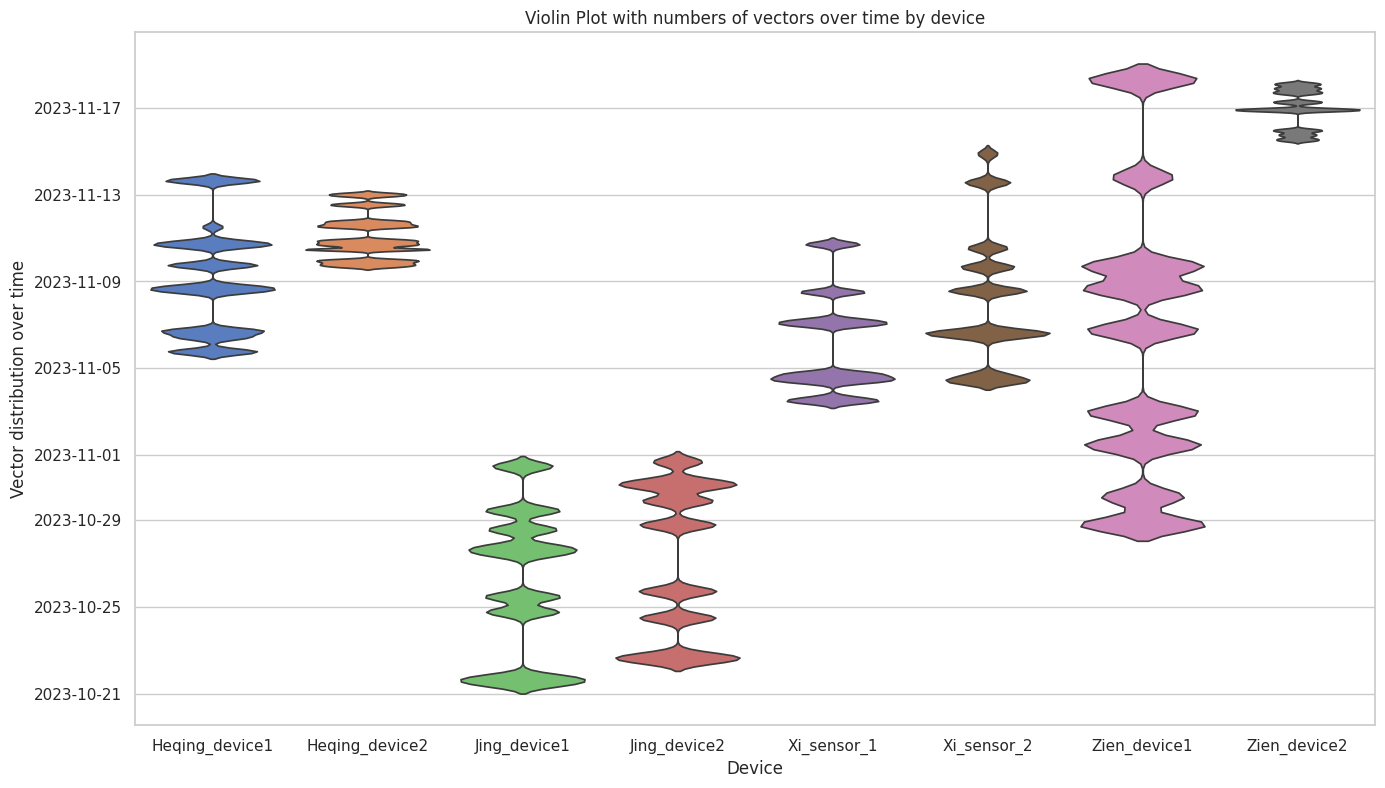

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
# Assuming copy_df is your DataFrame containing the data

# Set up the figure size based on the values in z
plt.figure(figsize=(16, 9))  # You can adjust the size as needed

# Create the violin plot
sns.violinplot(x="group", y="timestamp", data=vectors_df, split=False, palette="muted", inner=None,
               hue="group",
               legend=False, density_norm="count")
# plt.legend(title="Vector Count")

# Set labels and title
plt.xlabel("Device")
plt.ylabel("Vector distribution over time")
plt.title("Violin Plot with numbers of vectors over time by device")

# Show plot
plt.show()


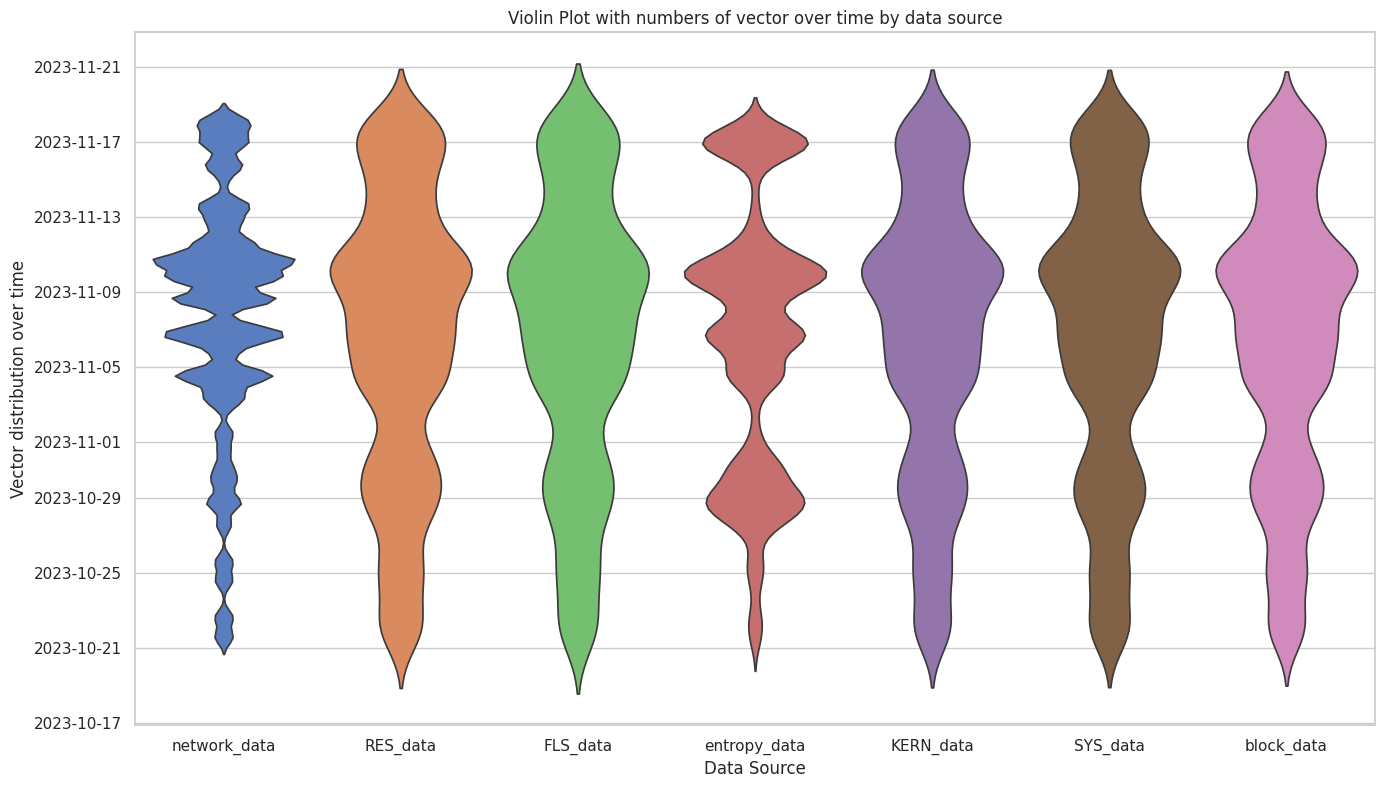

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
# Assuming copy_df is your DataFrame containing the data

# Set up the figure size based on the values in z
plt.figure(figsize=(16, 9))  # You can adjust the size as needed

# Create the violin plot
subset_df = vectors_df.sample(frac=0.1)
sns.violinplot(x="data_source", y="timestamp", data=subset_df, split=False, palette="muted", inner=None,
               hue="data_source",
               legend=False, density_norm="count")
# plt.legend(title="Vector Count")

# Set labels and title
plt.xlabel("Data Source")
plt.ylabel("Vector distribution over time")
plt.title("Violin Plot with numbers of vector over time by data source")

# Show plot
plt.show()


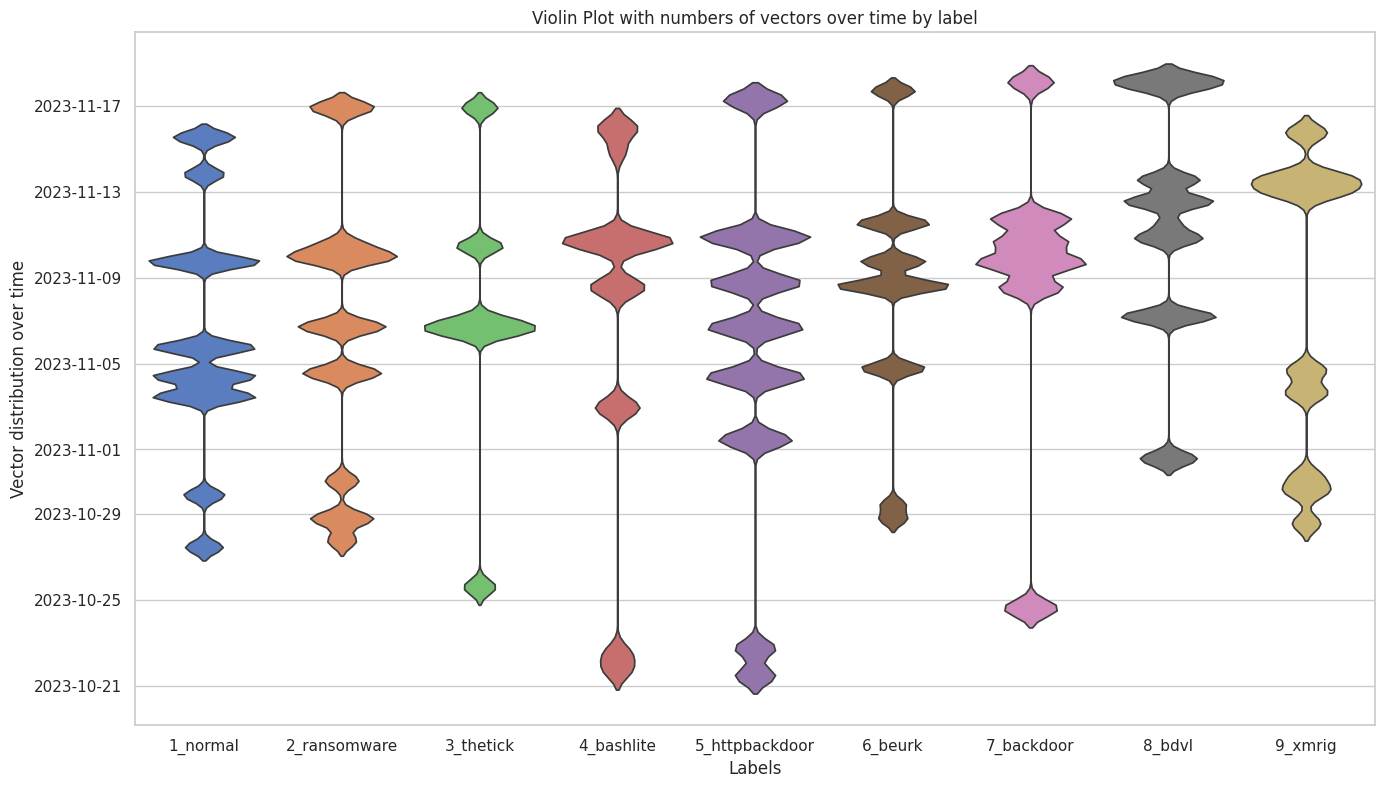

In [44]:

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
# Assuming copy_df is your DataFrame containing the data

# Set up the figure size based on the values in z
plt.figure(figsize=(16, 9))  # You can adjust the size as needed

# Create the violin plot
sns.violinplot(x="label", y="timestamp", data=experiment_df, split=False, palette="muted", inner=None,
               hue="label",
               legend=False, density_norm="count")
# plt.legend(title="Vector Count")

# Set labels and title
plt.xlabel("Labels")
plt.ylabel("Vector distribution over time")
plt.title("Violin Plot with numbers of vectors over time by label")

# Show plot
plt.show()


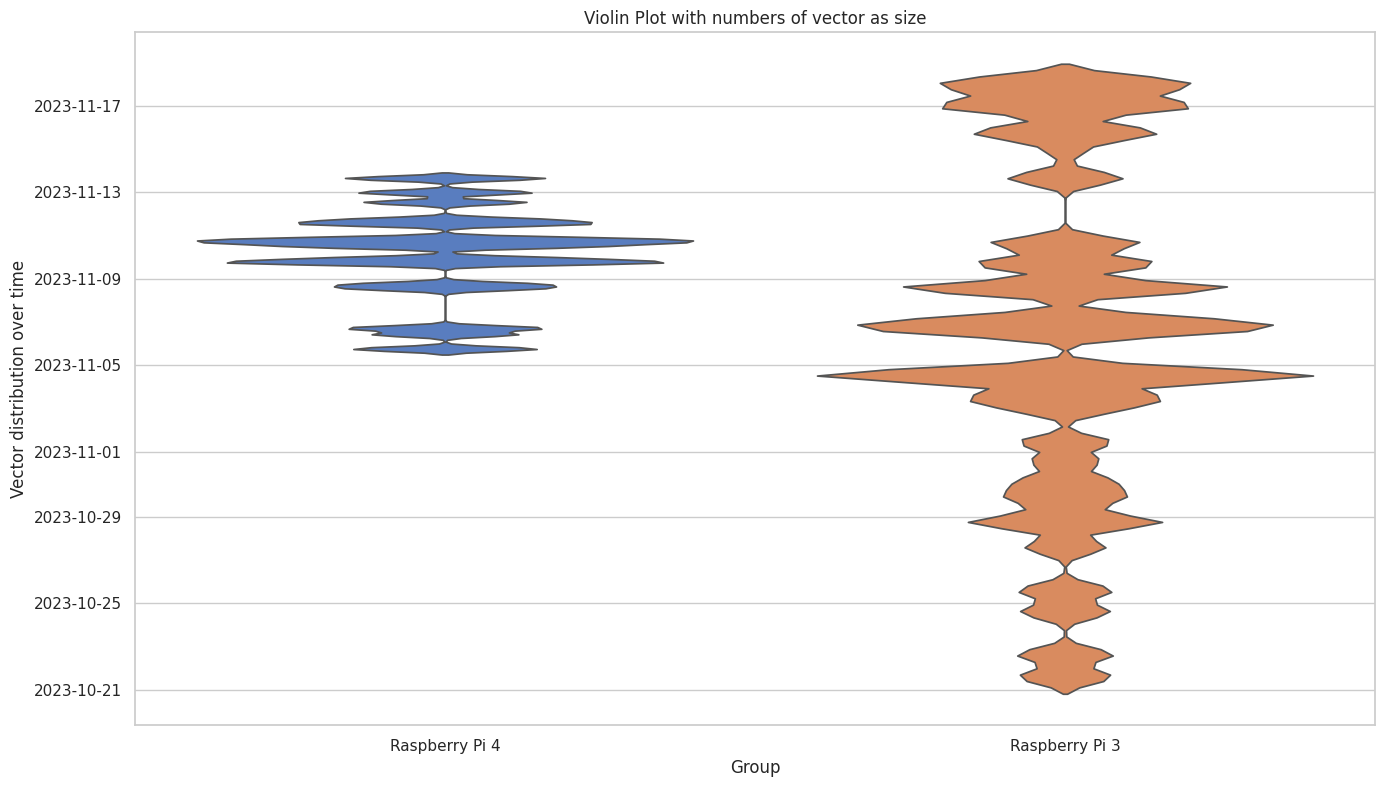

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
# Assuming copy_df is your DataFrame containing the data

# Set up the figure size based on the values in z
plt.figure(figsize=(16, 9))  # You can adjust the size as needed

# Create the violin plot
sns.violinplot(x="group", y="timestamp", data=device_fam_df, split=False, palette="muted", inner=None,
               hue="group",
               legend=False, density_norm="count")
# plt.legend(title="Vector Count")


# Set labels and title
plt.xlabel("Group")
plt.ylabel("Vector distribution over time")
plt.title("Violin Plot with numbers of vector as size")

# Show plot
plt.show()


#### Lineplot distribution over time

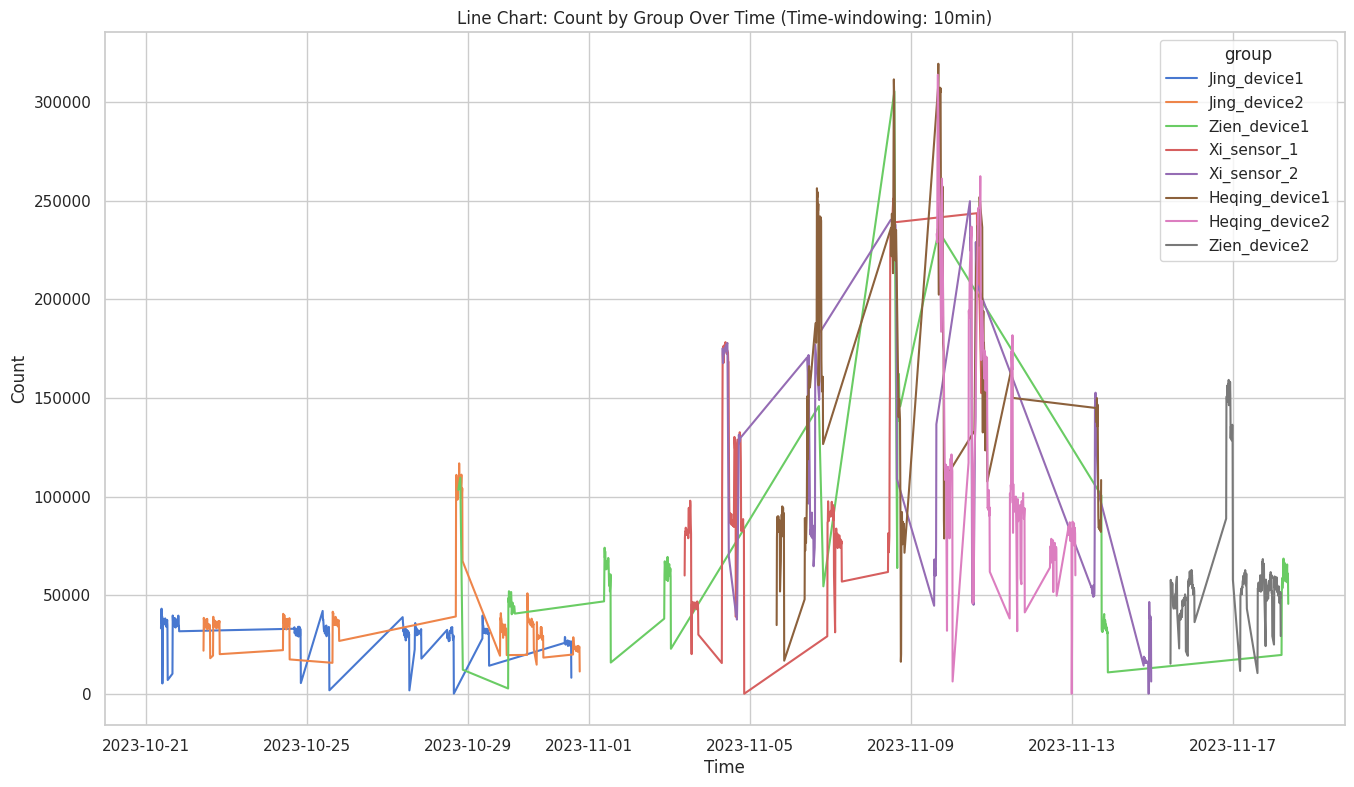

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
# Assuming vectors_df is your DataFrame containing the data

# Set up the figure size
plt.figure(figsize=(16, 9))

# Create the line plot
sns.lineplot(x="timestamp", hue="group", y="vector_count", data=time_sampled_df, palette="muted", estimator=lambda x: x,
             legend="full")

# Set labels and title
plt.xlabel("Time")
plt.ylabel("Count")
plt.title(f"Line Chart: Count by Group Over Time (Time-windowing: {TIME_WINDOW})")

plt.yscale("linear")
plt.ticklabel_format(style='plain', axis='y')

# Show plot
plt.show()

In [47]:
time_sampled_df

,timestamp,vector_count,group
0,2023-10-21 09:10:00,33175,Jing_device1
1,2023-10-21 09:20:00,38145,Jing_device1
2,2023-10-21 09:30:00,43150,Jing_device1
3,2023-10-21 09:40:00,35675,Jing_device1
4,2023-10-21 09:50:00,39280,Jing_device1
...,...,...,...
4026,2023-11-18 08:10:00,65580,Zien_device1
4027,2023-11-18 08:20:00,56405,Zien_device1
4028,2023-11-18 08:30:00,61010,Zien_device1
4029,2023-11-18 08:40:00,58670,Zien_device1


##### Table: Summary of collected features